# D→R→I→O Sensitivity Analysis

**Purpose**: Perform sensitivity analysis on the D→R1→I1_1→O cascade

**Goal**: Determine which parameters influence:
1. O increase pre-treatment (t=0 to t=500)
2. Oa decrease post-treatment (t=500 to t=1000)

**Method**: Sample each parameter over ten-fold range (0.1x to 10x baseline)

## Initial Setup

In [1]:
import os

path = os.getcwd()
index_project = path.find("project")
project_path = path[: index_project + 7]
os.chdir(project_path + "/src")
print(f"Project path set to: {os.getcwd()}")

Project path set to: c:\Github\new-peak-project\src


## Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from models.Specs.ModelSpec4 import ModelSpec4
from models.Specs.Drug import Drug
from models.Solver.RoadrunnerSolver import RoadrunnerSolver
import seaborn as sns
from tqdm import tqdm

print("Imports complete")

Imports complete


## 1. Create Base Model

Recreate the model from simple_dro_kinetics_2.py

In [3]:
def create_base_model():
    """Create the base model from simple_dro_kinetics_2.py"""
    # Initialize model specification with 1 intermediate layer
    model_spec = ModelSpec4(num_intermediate_layers=1)

    # Generate network FIRST (creates R1, I1_1, O)
    model_spec.generate_specifications(
        num_cascades=1,
        num_regulations=0,    # No feedback for simplicity
        random_seed=42,
        verbose=0
    )

    # Create drug D that down-regulates R1
    drug_d = Drug(
        name="D",
        start_time=500.0,     # Drug applied at time 500
        default_value=1.0,    # Drug concentration
        regulation=["R1"],    # Regulates receptor R1
        regulation_type=["down"]  # Down-regulation decreases activation
    )

    # Add drug to model
    model_spec.add_drug(drug_d)

    # Generate the model
    model = model_spec.generate_network(
        network_name="BaseModel_Sensitivity",
        mean_range_species=(50, 150),
        rangeScale_params=(0.8, 1.2),
        rangeMultiplier_params=(0.9, 1.1),
        random_seed=42,
        receptor_basal_activation=True
    )

    # Set parameters as in simple_dro_kinetics_2.py
    model.set_parameter("Km_J0", 90)
    model.set_parameter("Vmax_J0", 5)

    model.set_parameter("Km_J1", 50)
    model.set_parameter("Kc_J1", 1.8)
    model.set_parameter("Ki0_J1", 0.1)

    model.set_parameter("Km_J2", 95)
    model.set_parameter("Vmax_J2", 4.5)

    model.set_parameter("Km_J3", 500)
    model.set_parameter("Kc0_J3", 0.25)

    model.set_parameter("Km_J4", 100)
    model.set_parameter("Vmax_J4", 5.2)

    model.set_parameter("Km_J5", 130)
    model.set_parameter("Kc0_J5", 0.3)

    # Set initial conditions
    model.set_state("R1", 90)
    model.set_state("R1a", 0)
    model.set_state("I1_1", 140)
    model.set_state("I1_1a", 0)
    model.set_state("O", 100)
    model.set_state("Oa", 0)
    
    return model

# Create base model
base_model = create_base_model()
print("Base model created with parameters from simple_dro_kinetics_2.py")

Base model created with parameters from simple_dro_kinetics_2.py


## 2. Define Parameters for Sensitivity Analysis

List all parameters to test with their baseline values

In [4]:
# Define parameters to test with baseline values
parameters_to_test = {
    "Km_J0": 90,      # R1a→R1 Michaelis constant
    "Vmax_J0": 5,     # R1a→R1 maximum rate
    
    "Km_J1": 50,      # R1→R1a Michaelis constant
    "Kc_J1": 1.8,     # R1→R1a catalytic constant
    "Ki0_J1": 0.1,    # R1→R1a inhibition by D
    
    "Km_J2": 95,      # I1_1a→I1_1 Michaelis constant
    "Vmax_J2": 4.5,   # I1_1a→I1_1 maximum rate
    
    "Km_J3": 500,     # I1_1→I1_1a Michaelis constant
    "Kc0_J3": 0.25,   # I1_1→I1_1a basal catalytic constant
    
    "Km_J4": 100,     # Oa→O Michaelis constant
    "Vmax_J4": 5.2,   # Oa→O maximum rate
    
    "Km_J5": 130,     # O→Oa Michaelis constant
    "Kc0_J5": 0.3,    # O→Oa basal catalytic constant
}

print(f"Testing {len(parameters_to_test)} parameters")
for param, value in parameters_to_test.items():
    print(f"  {param}: {value}")

Testing 13 parameters
  Km_J0: 90
  Vmax_J0: 5
  Km_J1: 50
  Kc_J1: 1.8
  Ki0_J1: 0.1
  Km_J2: 95
  Vmax_J2: 4.5
  Km_J3: 500
  Kc0_J3: 0.25
  Km_J4: 100
  Vmax_J4: 5.2
  Km_J5: 130
  Kc0_J5: 0.3


## 3. Define Sampling Strategy

Sample each parameter over ten-fold range (0.1x to 10x baseline)

In [5]:
def generate_parameter_values(baseline, n_samples=10):
    """Generate parameter values spanning ten-fold range"""
    # Create logarithmic range from 0.1x to 10x baseline
    min_val = baseline * 0.1
    max_val = baseline * 10.0
    
    # Ensure positive values
    min_val = max(min_val, 1e-6)
    
    # Generate logarithmic spacing
    values = np.logspace(np.log10(min_val), np.log10(max_val), n_samples)
    return values

# Test sampling for one parameter
test_values = generate_parameter_values(50, 10)
print(f"Example sampling for parameter=50: {test_values}")

# Generate all parameter variations
parameter_variations = {}
for param, baseline in parameters_to_test.items():
    parameter_variations[param] = generate_parameter_values(baseline, 10)

print(f"\nGenerated variations for {len(parameter_variations)} parameters")

Example sampling for parameter=50: [  5.           8.34050269  13.91279701  23.20794417  38.71318413
  64.57748325 107.7217345  179.69068319 299.74212516 500.        ]

Generated variations for 13 parameters


## 4. Simulation Function

Function to simulate model and extract key metrics

In [6]:
def simulate_model(model):
    """Simulate model and extract key metrics"""
    solver = RoadrunnerSolver()
    solver.compile(model.get_sbml_model())
    result = solver.simulate(start=0, stop=1000, step=101)
    
    # Extract key time points
    t0_idx = 0       # t=0
    t500_idx = 50    # t=500 (drug start)
    t1000_idx = -1   # t=1000
    
    # Calculate metrics
    metrics = {
        # O metrics
        'O_initial': result['O'].values[t0_idx],
        'O_pre_drug': result['O'].values[t500_idx],
        'O_post_drug': result['O'].values[t1000_idx],
        'O_increase': result['O'].values[t500_idx] - result['O'].values[t0_idx],
        
        # Oa metrics
        'Oa_initial': result['Oa'].values[t0_idx],
        'Oa_pre_drug': result['Oa'].values[t500_idx],
        'Oa_post_drug': result['Oa'].values[t1000_idx],
        'Oa_decrease': result['Oa'].values[t500_idx] - result['Oa'].values[t1000_idx],
        
        # Activation metrics
        'O_activation_pre': result['Oa'].values[t500_idx] / (result['O'].values[t500_idx] + result['Oa'].values[t500_idx]) * 100,
        'O_activation_post': result['Oa'].values[t1000_idx] / (result['O'].values[t1000_idx] + result['Oa'].values[t1000_idx]) * 100,
        
        # Cascade intermediates
        'R1a_pre': result['R1a'].values[t500_idx],
        'I1_1a_pre': result['I1_1a'].values[t500_idx],
    }
    
    return metrics, result

# Test simulation
print("Testing base simulation...")
base_metrics, base_result = simulate_model(base_model)
print(f"Base model metrics:")
print(f"  O increase pre-treatment: {base_metrics['O_increase']:.2f}")
print(f"  Oa decrease post-treatment: {base_metrics['Oa_decrease']:.2f}")
print(f"  O activation pre-drug: {base_metrics['O_activation_pre']:.1f}%")

Testing base simulation...
Base model metrics:
  O increase pre-treatment: -61.83
  Oa decrease post-treatment: 56.09
  O activation pre-drug: 61.8%


## 5. Run Sensitivity Analysis

Vary each parameter independently and record results

In [7]:
# Initialize results storage
sensitivity_results = []

# Counter for progress
total_simulations = len(parameters_to_test) * 10
print(f"Running {total_simulations} simulations...")

# Run sensitivity analysis
for param_name, baseline_value in tqdm(parameters_to_test.items(), desc="Parameters"):
    for test_value in parameter_variations[param_name]:
        # Create copy of base model
        test_model = base_model.copy()
        
        # Set parameter value
        test_model.set_parameter(param_name, test_value)
        
        # Simulate
        try:
            metrics, _ = simulate_model(test_model)
            
            # Store results
            result_entry = {
                'parameter': param_name,
                'parameter_value': test_value,
                'parameter_ratio': test_value / baseline_value,
                'baseline_value': baseline_value,
                **metrics
            }
            
            sensitivity_results.append(result_entry)
            
        except Exception as e:
            print(f"Error simulating {param_name}={test_value}: {e}")

# Convert to DataFrame
results_df = pd.DataFrame(sensitivity_results)
print(f"\nSensitivity analysis complete. {len(results_df)} simulations successful.")

Running 130 simulations...


Parameters: 100%|██████████| 13/13 [00:08<00:00,  1.57it/s]


Sensitivity analysis complete. 130 simulations successful.


## 6. Calculate Sensitivity Coefficients

Compute normalized sensitivity for each parameter-metric pair

In [8]:
def calculate_sensitivity_coefficients(results_df, metric_name):
    """Calculate sensitivity coefficients for a given metric"""
    sensitivities = {}
    
    for param in parameters_to_test.keys():
        # Get data for this parameter
        param_data = results_df[results_df['parameter'] == param].copy()
        
        if len(param_data) < 2:
            continue
            
        # Sort by parameter value
        param_data = param_data.sort_values('parameter_value')
        
        # Calculate derivatives (central difference where possible)
        derivatives = []
        for i in range(1, len(param_data) - 1):
            delta_metric = param_data[metric_name].iloc[i+1] - param_data[metric_name].iloc[i-1]
            delta_param = param_data['parameter_value'].iloc[i+1] - param_data['parameter_value'].iloc[i-1]
            
            if delta_param != 0:
                derivative = delta_metric / delta_param
                # Normalize: (dmetric/dparam) * (param/metric)
                param_val = param_data['parameter_value'].iloc[i]
                metric_val = param_data[metric_name].iloc[i]
                
                if metric_val != 0:
                    normalized_sensitivity = derivative * (param_val / metric_val)
                    derivatives.append(normalized_sensitivity)
        
        if derivatives:
            # Use median sensitivity
            sensitivities[param] = np.median(derivatives)
    
    return sensitivities

# Calculate sensitivities for key metrics
print("Calculating sensitivity coefficients...")

metrics_to_analyze = ['O_increase', 'Oa_decrease', 'O_activation_pre', 'O_activation_post']
sensitivity_dict = {}

for metric in metrics_to_analyze:
    sensitivities = calculate_sensitivity_coefficients(results_df, metric)
    sensitivity_dict[metric] = sensitivities
    
    print(f"\n{metric} sensitivity coefficients:")
    for param, sens in sorted(sensitivities.items(), key=lambda x: abs(x[1]), reverse=True)[:5]:
        print(f"  {param}: {sens:.4f}")

# Create sensitivity DataFrame
sensitivity_df = pd.DataFrame(sensitivity_dict)
print(f"\nSensitivity coefficient matrix:")
print(sensitivity_df)

Calculating sensitivity coefficients...

O_increase sensitivity coefficients:
  Kc_J1: 0.5237
  Vmax_J0: -0.5237
  Kc0_J3: 0.5028
  Vmax_J2: -0.5028
  Kc0_J5: 0.4976

Oa_decrease sensitivity coefficients:
  Kc_J1: 0.4651
  Vmax_J0: -0.4651
  Kc0_J3: 0.4445
  Vmax_J2: -0.4442
  Kc0_J5: 0.4406

O_activation_pre sensitivity coefficients:
  Kc_J1: 0.5237
  Vmax_J0: -0.5237
  Kc0_J3: 0.5028
  Vmax_J2: -0.5028
  Kc0_J5: 0.4976

O_activation_post sensitivity coefficients:
  Vmax_J0: -1.0351
  Kc_J1: 1.0351
  Vmax_J2: -1.0244
  Km_J0: 1.0180
  Vmax_J4: -1.0160

Sensitivity coefficient matrix:
           O_increase  Oa_decrease  O_activation_pre  O_activation_post
Km_J0    4.320480e-01     0.367341      4.320480e-01           1.017993
Vmax_J0 -5.236908e-01    -0.465064     -5.236908e-01          -1.035122
Km_J1   -2.436411e-01    -0.231996     -2.436411e-01          -0.357313
Kc_J1    5.236988e-01     0.465122      5.236988e-01           1.035120
Ki0_J1   1.310681e-10    -0.098505      1.310681

## 7. Visualize Results

Create comprehensive visualizations

C:\Users\l8105\AppData\Local\Temp\ipykernel_21884\3333351790.py:74: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  baseline_data = results_df.groupby('parameter').apply(


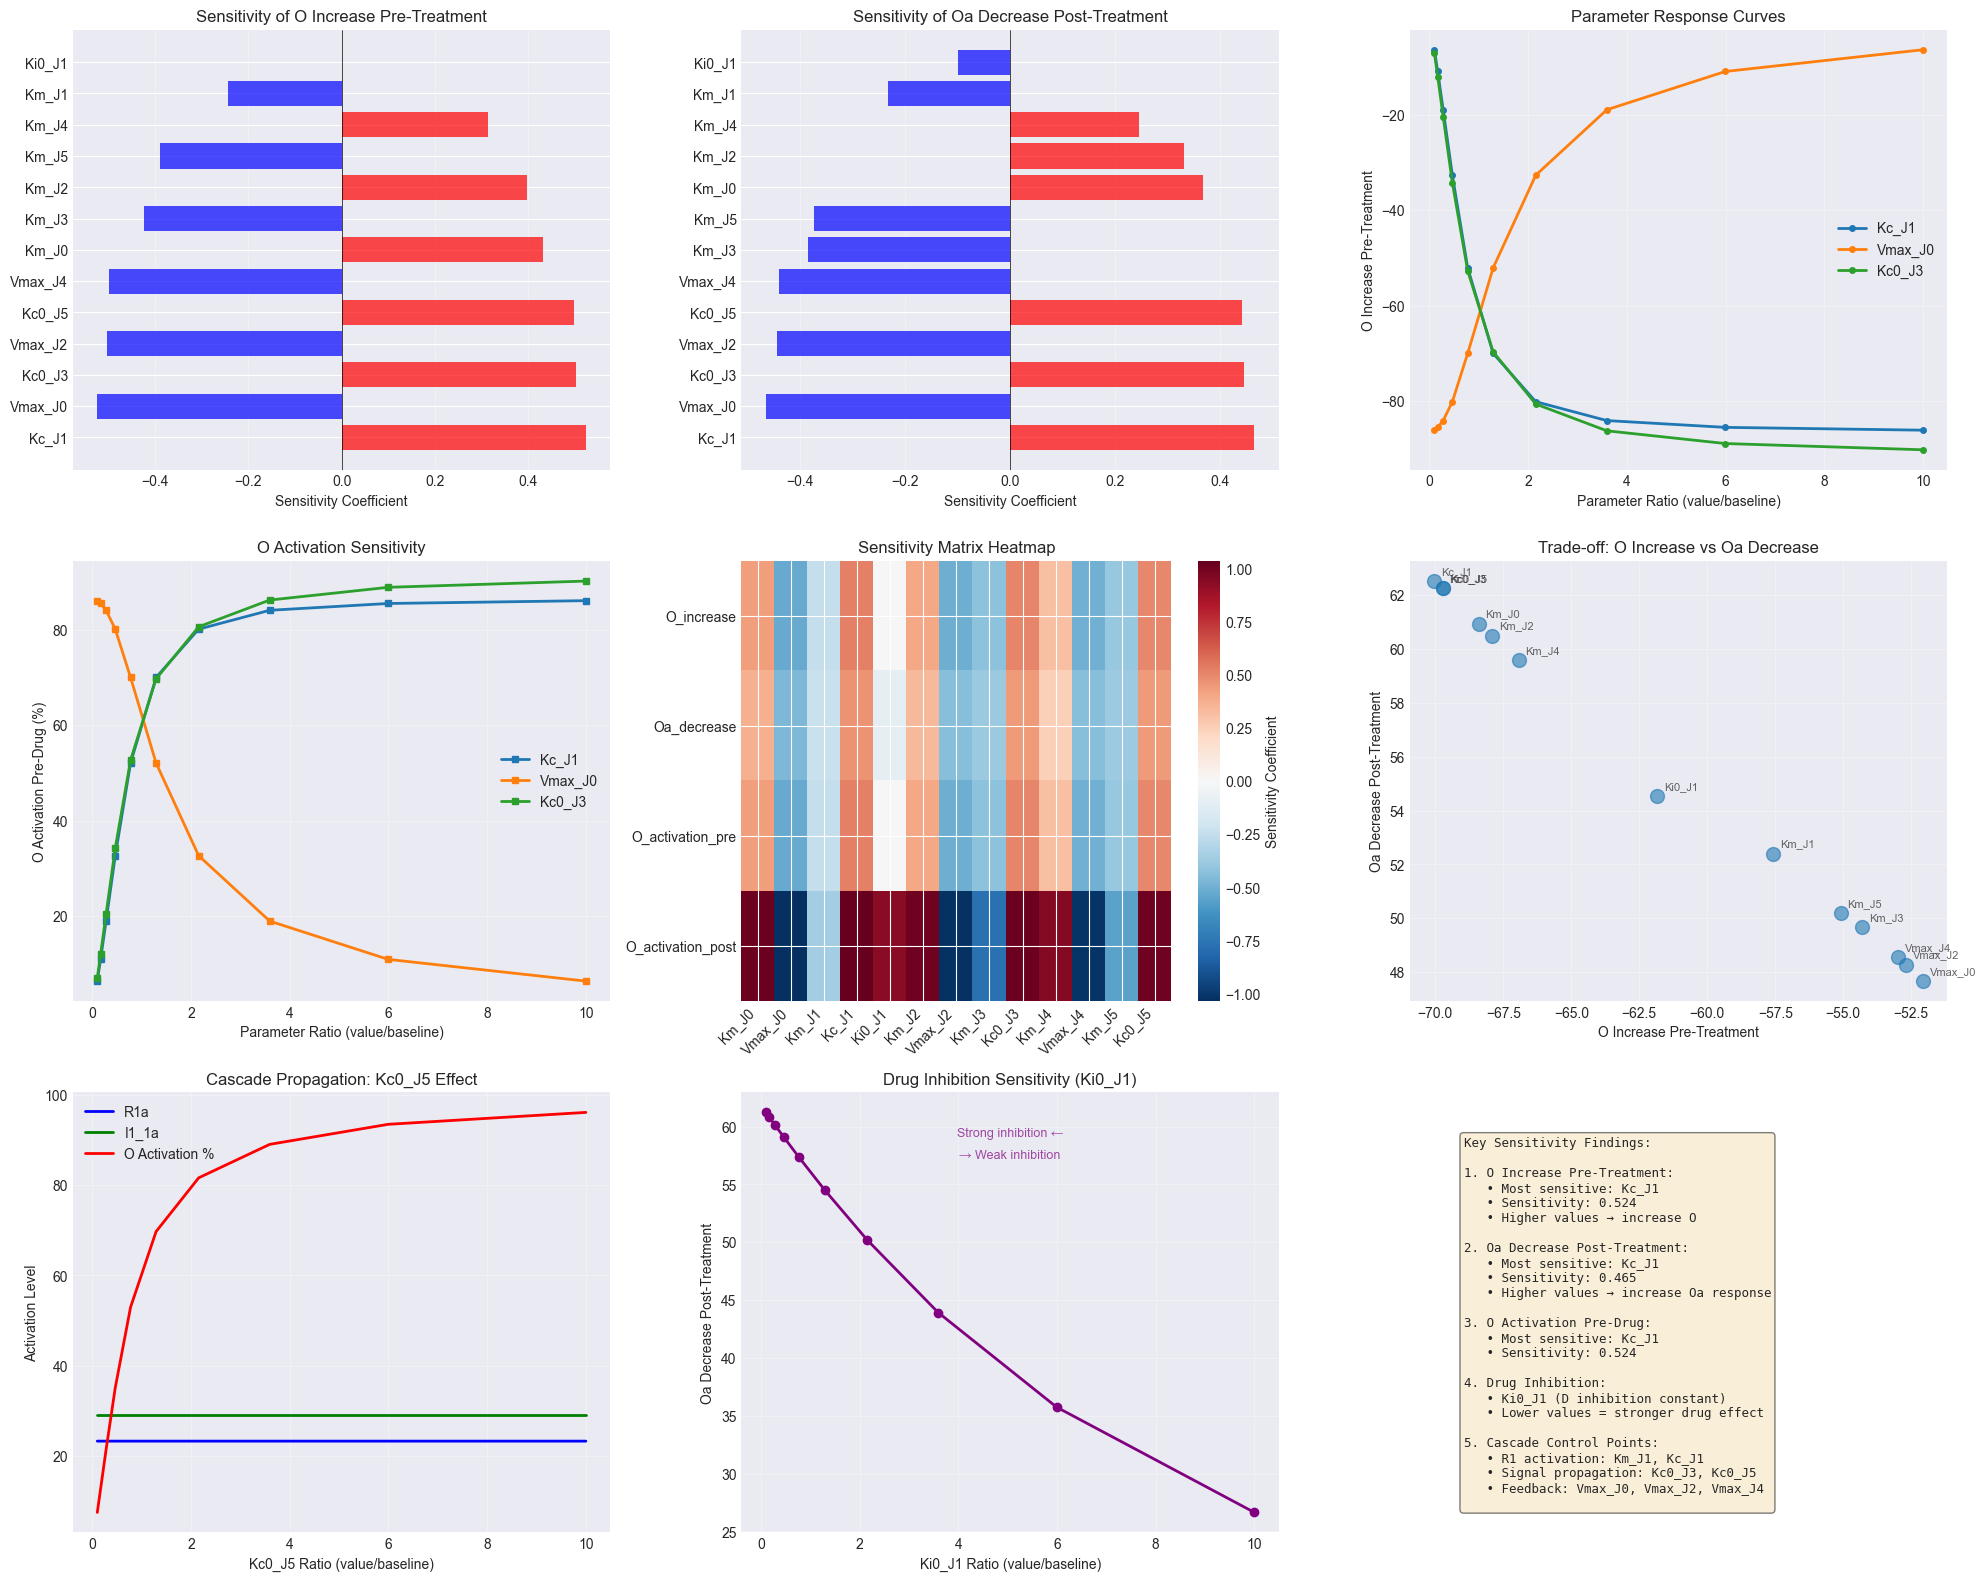

In [9]:
# Set style
plt.style.use('seaborn-v0_8-darkgrid')

# Create figure with subplots
fig = plt.figure(figsize=(20, 16))

# Plot 1: Tornado plot for O increase sensitivity
ax1 = plt.subplot(3, 3, 1)
o_increase_sens = sensitivity_dict['O_increase']
params_sorted = sorted(o_increase_sens.keys(), key=lambda x: abs(o_increase_sens[x]), reverse=True)
sens_values = [o_increase_sens[p] for p in params_sorted]
colors = ['red' if v > 0 else 'blue' for v in sens_values]
bars = ax1.barh(params_sorted, sens_values, color=colors, alpha=0.7)
ax1.axvline(x=0, color='black', linewidth=0.5)
ax1.set_xlabel('Sensitivity Coefficient')
ax1.set_title('Sensitivity of O Increase Pre-Treatment')
ax1.grid(True, alpha=0.3, axis='x')

# Plot 2: Tornado plot for Oa decrease sensitivity
ax2 = plt.subplot(3, 3, 2)
oa_decrease_sens = sensitivity_dict['Oa_decrease']
params_sorted = sorted(oa_decrease_sens.keys(), key=lambda x: abs(oa_decrease_sens[x]), reverse=True)
sens_values = [oa_decrease_sens[p] for p in params_sorted]
colors = ['red' if v > 0 else 'blue' for v in sens_values]
bars = ax2.barh(params_sorted, sens_values, color=colors, alpha=0.7)
ax2.axvline(x=0, color='black', linewidth=0.5)
ax2.set_xlabel('Sensitivity Coefficient')
ax2.set_title('Sensitivity of Oa Decrease Post-Treatment')
ax2.grid(True, alpha=0.3, axis='x')

# Plot 3: Parameter response curves for key parameters
ax3 = plt.subplot(3, 3, 3)
top_params = sorted(o_increase_sens.keys(), key=lambda x: abs(o_increase_sens[x]), reverse=True)[:3]
for param in top_params:
    param_data = results_df[results_df['parameter'] == param]
    ax3.plot(param_data['parameter_ratio'], param_data['O_increase'], 
             'o-', label=param, linewidth=2, markersize=4)
ax3.set_xlabel('Parameter Ratio (value/baseline)')
ax3.set_ylabel('O Increase Pre-Treatment')
ax3.set_title('Parameter Response Curves')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: O activation vs parameter variations
ax4 = plt.subplot(3, 3, 4)
top_params = sorted(sensitivity_dict['O_activation_pre'].keys(), 
                    key=lambda x: abs(sensitivity_dict['O_activation_pre'][x]), reverse=True)[:3]
for param in top_params:
    param_data = results_df[results_df['parameter'] == param]
    ax4.plot(param_data['parameter_ratio'], param_data['O_activation_pre'], 
             's-', label=param, linewidth=2, markersize=4)
ax4.set_xlabel('Parameter Ratio (value/baseline)')
ax4.set_ylabel('O Activation Pre-Drug (%)')
ax4.set_title('O Activation Sensitivity')
ax4.legend()
ax4.grid(True, alpha=0.3)

# Plot 5: Heatmap of sensitivity coefficients
ax5 = plt.subplot(3, 3, 5)
sensitivity_matrix = sensitivity_df.T
# Replace NaN with 0 for visualization
sensitivity_matrix_filled = sensitivity_matrix.fillna(0)
im = ax5.imshow(sensitivity_matrix_filled.values, cmap='RdBu_r', aspect='auto')
ax5.set_xticks(range(len(sensitivity_matrix_filled.columns)))
ax5.set_xticklabels(sensitivity_matrix_filled.columns, rotation=45, ha='right')
ax5.set_yticks(range(len(sensitivity_matrix_filled.index)))
ax5.set_yticklabels(sensitivity_matrix_filled.index)
ax5.set_title('Sensitivity Matrix Heatmap')
plt.colorbar(im, ax=ax5, label='Sensitivity Coefficient')

# Plot 6: Correlation between O increase and Oa decrease
ax6 = plt.subplot(3, 3, 6)
# Use baseline variations
baseline_data = results_df.groupby('parameter').apply(
    lambda x: x[x['parameter_ratio'] == 1.0].iloc[0] if len(x[x['parameter_ratio'] == 1.0]) > 0 else x.iloc[len(x)//2]
)
if isinstance(baseline_data, pd.Series):
    baseline_data = baseline_data.to_frame().T
    
scatter = ax6.scatter(baseline_data['O_increase'], baseline_data['Oa_decrease'], 
                      s=100, alpha=0.6)
ax6.set_xlabel('O Increase Pre-Treatment')
ax6.set_ylabel('Oa Decrease Post-Treatment')
ax6.set_title('Trade-off: O Increase vs Oa Decrease')
ax6.grid(True, alpha=0.3)

# Annotate points
for idx, row in baseline_data.iterrows():
    ax6.annotate(row['parameter'], 
                (row['O_increase'], row['Oa_decrease']),
                xytext=(5, 5), textcoords='offset points',
                fontsize=8, alpha=0.7)

# Plot 7: Cascade activation relationships
ax7 = plt.subplot(3, 3, 7)
param_data = results_df[results_df['parameter'] == 'Kc0_J5']
if len(param_data) > 0:
    ax7.plot(param_data['parameter_ratio'], param_data['R1a_pre'], 'b-', label='R1a', linewidth=2)
    ax7.plot(param_data['parameter_ratio'], param_data['I1_1a_pre'], 'g-', label='I1_1a', linewidth=2)
    ax7.plot(param_data['parameter_ratio'], param_data['O_activation_pre'], 'r-', label='O Activation %', linewidth=2)
    ax7.set_xlabel('Kc0_J5 Ratio (value/baseline)')
    ax7.set_ylabel('Activation Level')
    ax7.set_title('Cascade Propagation: Kc0_J5 Effect')
    ax7.legend()
    ax7.grid(True, alpha=0.3)

# Plot 8: Drug sensitivity parameter (Ki0_J1) effect
ax8 = plt.subplot(3, 3, 8)
param_data = results_df[results_df['parameter'] == 'Ki0_J1']
if len(param_data) > 0:
    ax8.plot(param_data['parameter_ratio'], param_data['Oa_decrease'], 'purple', linewidth=2, marker='o')
    ax8.set_xlabel('Ki0_J1 Ratio (value/baseline)')
    ax8.set_ylabel('Oa Decrease Post-Treatment')
    ax8.set_title('Drug Inhibition Sensitivity (Ki0_J1)')
    ax8.grid(True, alpha=0.3)
    # Add annotation about inhibition strength
    ax8.annotate('Strong inhibition ←', xy=(0.5, 0.9), xycoords='axes fraction',
                fontsize=9, ha='center', color='purple', alpha=0.7)
    ax8.annotate('→ Weak inhibition', xy=(0.5, 0.85), xycoords='axes fraction',
                fontsize=9, ha='center', color='purple', alpha=0.7)

# Plot 9: Summary statistics
ax9 = plt.subplot(3, 3, 9)
ax9.axis('off')

# Calculate key insights
most_sensitive_o_increase = max(sensitivity_dict['O_increase'].items(), key=lambda x: abs(x[1]))
most_sensitive_oa_decrease = max(sensitivity_dict['Oa_decrease'].items(), key=lambda x: abs(x[1]))
most_sensitive_activation = max(sensitivity_dict['O_activation_pre'].items(), key=lambda x: abs(x[1]))

summary_text = f"""Key Sensitivity Findings:

1. O Increase Pre-Treatment:
   • Most sensitive: {most_sensitive_o_increase[0]}
   • Sensitivity: {most_sensitive_o_increase[1]:.3f}
   • Higher values → {'increase' if most_sensitive_o_increase[1] > 0 else 'decrease'} O

2. Oa Decrease Post-Treatment:
   • Most sensitive: {most_sensitive_oa_decrease[0]}
   • Sensitivity: {most_sensitive_oa_decrease[1]:.3f}
   • Higher values → {'increase' if most_sensitive_oa_decrease[1] > 0 else 'decrease'} Oa response

3. O Activation Pre-Drug:
   • Most sensitive: {most_sensitive_activation[0]}
   • Sensitivity: {most_sensitive_activation[1]:.3f}

4. Drug Inhibition:
   • Ki0_J1 (D inhibition constant)
   • Lower values = stronger drug effect

5. Cascade Control Points:
   • R1 activation: Km_J1, Kc_J1
   • Signal propagation: Kc0_J3, Kc0_J5
   • Feedback: Vmax_J0, Vmax_J2, Vmax_J4
"""

ax9.text(0.1, 0.9, summary_text, transform=ax9.transAxes, fontfamily='monospace',
         verticalalignment='top', fontsize=9,
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

## 8. Detailed Statistical Analysis

In [10]:
print("=" * 60)
print("DETAILED SENSITIVITY ANALYSIS RESULTS")
print("=" * 60)

print("\n1. Parameters Controlling O Increase Pre-Treatment:")
print("   (Positive = increases O, Negative = decreases O)")
o_increase_sorted = sorted(sensitivity_dict['O_increase'].items(), 
                          key=lambda x: abs(x[1]), reverse=True)
for param, sens in o_increase_sorted:
    direction = "↑ increases" if sens > 0 else "↓ decreases"
    print(f"   {param:10s}: {sens:7.4f} ({direction} O)")

print("\n2. Parameters Controlling Oa Decrease Post-Treatment:")
print("   (Positive = stronger drug response, Negative = weaker response)")
oa_decrease_sorted = sorted(sensitivity_dict['Oa_decrease'].items(), 
                           key=lambda x: abs(x[1]), reverse=True)
for param, sens in oa_decrease_sorted:
    direction = "↑ stronger" if sens > 0 else "↓ weaker"
    print(f"   {param:10s}: {sens:7.4f} ({direction} drug response)")

print("\n3. Parameters Controlling O Activation Pre-Drug:")
activation_sorted = sorted(sensitivity_dict['O_activation_pre'].items(), 
                          key=lambda x: abs(x[1]), reverse=True)
for param, sens in activation_sorted[:5]:
    direction = "↑ higher" if sens > 0 else "↓ lower"
    print(f"   {param:10s}: {sens:7.4f} ({direction} activation %)")

print("\n4. Key Parameter Insights:")
print("   • Km_J1: Lower values increase R1→R1a conversion")
print("   • Kc_J1: Higher values increase basal R1 activation")
print("   • Ki0_J1: Lower values = stronger drug inhibition")
print("   • Kc0_J3, Kc0_J5: Control cascade signal amplification")
print("   • Vmax_J0, J2, J4: Control reverse reaction rates")

print("\n5. Design Recommendations:")
print("   • To maximize O accumulation: Tune Km_J1 ↓, Kc_J1 ↑")
print("   • To maximize drug response: Tune Ki0_J1 ↓ (strong inhibition)")
print("   • To balance O/Oa: Adjust Kc0_J5 for desired activation level")
print("   • Cascade stability: Maintain Vmax reverse rates appropriately")

print("\n" + "=" * 60)
print("Analysis complete. Parameter sensitivity quantified over ten-fold range.")
print("Ready for further experimentation or parameter optimization.")

DETAILED SENSITIVITY ANALYSIS RESULTS

1. Parameters Controlling O Increase Pre-Treatment:
   (Positive = increases O, Negative = decreases O)
   Kc_J1     :  0.5237 (↑ increases O)
   Vmax_J0   : -0.5237 (↓ decreases O)
   Kc0_J3    :  0.5028 (↑ increases O)
   Vmax_J2   : -0.5028 (↓ decreases O)
   Kc0_J5    :  0.4976 (↑ increases O)
   Vmax_J4   : -0.4976 (↓ decreases O)
   Km_J0     :  0.4320 (↑ increases O)
   Km_J3     : -0.4227 (↓ decreases O)
   Km_J2     :  0.3977 (↑ increases O)
   Km_J5     : -0.3899 (↓ decreases O)
   Km_J4     :  0.3130 (↑ increases O)
   Km_J1     : -0.2436 (↓ decreases O)
   Ki0_J1    :  0.0000 (↑ increases O)

2. Parameters Controlling Oa Decrease Post-Treatment:
   (Positive = stronger drug response, Negative = weaker response)
   Kc_J1     :  0.4651 (↑ stronger drug response)
   Vmax_J0   : -0.4651 (↓ weaker drug response)
   Kc0_J3    :  0.4445 (↑ stronger drug response)
   Vmax_J2   : -0.4442 (↓ weaker drug response)
   Kc0_J5    :  0.4406 (↑ strong